# CAPSTONE PROJECT
# Predictive Modeling for COVID-19 trend in Public Health

NAME: Ayoka Noble Onyedikachi
ID: FE/23/4356734 
# Loading & Inspecting the Datasets
CONTENT IN THE DATASET

full_grouped.csv - Day to day country wise no. of cases (Has County/State/Province level data)
covid_19_clean_complete.csv - Day to day country wise no. of cases (Doesn't have County/State/Province level data)3.
country_wise_latest.csv - Latest country level no. of case4. s
day_wise.csv - Day wise no. of cases (Doesn't have country level dat5. a
usa_county_wise.csv - Day to day county level no. of cases
worldometer_data.csv - Latest data from https://www.worldometers.info/

# Importing important libraries 

In [28]:
# Importing necessary libraries for the notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from statsmodels.tsa.arima.model import ARIMA

# Ensuring display settings are optimized for output
pd.set_option('display.max_columns', None)

# Load the Datasets

In [29]:
# Load the datasets (assuming filenames and paths are known)
try:
    # Replace with actual paths for the files in your environment
    worldometer = pd.read_csv('worldometer_data.csv')
    covid19_clean = pd.read_csv('covid_19_clean_complete.csv')
    day_wise = pd.read_csv('day_wise.csv')
    full_grouped = pd.read_csv('full_grouped.csv')
    country_wise = pd.read_csv('country_wise_latest.csv')
    usa_county_wise = pd.read_csv('usa_county_wise.csv')
except FileNotFoundError as e:
    print("Error: File not found. Please check the dataset paths and filenames.", e)

# Data Cleaning

In [30]:
# Data Preprocessing: Handle missing values and ensure clean datasets

# Converting 'Date' to datetime format
if 'Date' in covid19_clean.columns:
    covid19_clean['Date'] = pd.to_datetime(covid19_clean['Date'], errors='coerce')

# Fill missing numeric values with 0 where appropriate
covid19_clean.fillna({'Confirmed': 0, 'Deaths': 0, 'Recovered': 0, 'Active': 0}, inplace=True)

# Derive new features
covid19_clean['Mortality Rate'] = (covid19_clean['Deaths'] / covid19_clean['Confirmed']) * 100
covid19_clean['Cases per 100k Population'] = (covid19_clean['Confirmed'] / 1_000_000) * 100_000
covid19_clean['Daily Growth Rate'] = covid19_clean['Confirmed'].pct_change().fillna(0)

# Exploratory Data Analysis (EDA) & Visuaization

In [31]:
# Inspect column names
print(covid19_clean.columns)
print(worldometer.columns)

# Merge `covid19_clean` with `worldometer` on 'Country/Region'
covid19_clean = covid19_clean.merge(
    worldometer[['Country/Region', 'Population']], 
    left_on='Country/Region', 
    right_on='Country/Region', 
    how='left'
)

# Check the merged dataset to ensure it worked correctly
print(covid19_clean.head())

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed',
       'Deaths', 'Recovered', 'Active', 'WHO Region', 'Mortality Rate',
       'Cases per 100k Population', 'Daily Growth Rate'],
      dtype='object')
Index(['Country/Region', 'Continent', 'Population', 'TotalCases', 'NewCases',
       'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered',
       'ActiveCases', 'Serious,Critical', 'Tot Cases/1M pop', 'Deaths/1M pop',
       'TotalTests', 'Tests/1M pop', 'WHO Region'],
      dtype='object')
  Province/State Country/Region       Lat       Long       Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953 2020-01-22          0   
1            NaN        Albania  41.15330  20.168300 2020-01-22          0   
2            NaN        Algeria  28.03390   1.659600 2020-01-22          0   
3            NaN        Andorra  42.50630   1.521800 2020-01-22          0   
4            NaN         Angola -11.20270  17.873900 2020-01-22          0   



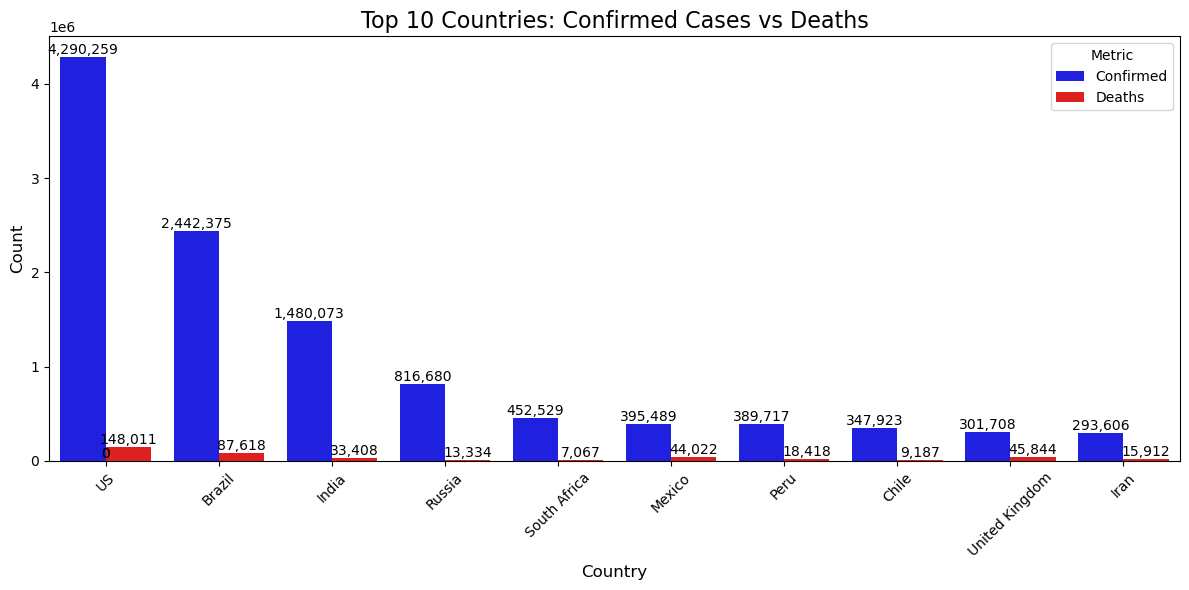

In [33]:
# Calculate Mortality Rate
covid19_clean['Mortality Rate'] = (covid19_clean['Deaths'] / covid19_clean['Confirmed']) * 100

import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 10 countries by confirmed cases
top_countries = country_wise.nlargest(10, 'Confirmed')

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Melt the data for a grouped bar chart
top_countries_melted = top_countries.melt(
    id_vars=['Country/Region'], 
    value_vars=['Confirmed', 'Deaths'], 
    var_name='Metric', 
    value_name='Count'
)

# Plot the grouped bar chart using sns.barplot
sns.barplot(data=top_countries_melted, x='Country/Region', y='Count', hue='Metric', palette={'Confirmed': 'blue', 'Deaths': 'red'}, ax=ax)

# Add annotations for each bar
for bar in ax.patches:
    ax.annotate(
        f'{int(bar.get_height()):,}',  # Format as thousands
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Set title and labels
ax.set_title('Top 10 Countries: Confirmed Cases vs Deaths', fontsize=16)
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Adjust legend position
ax.legend(title='Metric', loc='upper right', fontsize=10)

# Save the plot and show it
plt.tight_layout()  # Ensures everything fits within the plot area
plt.savefig("Top_10_Countries_Confirmed_vs_Deaths_Annotated.png", dpi=300)  # Save for report
plt.show()

# Feature Engineering

In [34]:
covid19_clean['Daily Growth Rate'] = covid19_clean['Confirmed'].pct_change().fillna(0)
covid19_clean['Mortality Rate'] = (covid19_clean['Deaths'] / covid19_clean['Confirmed']) * 100
covid19_clean['Cases per 100k Population'] = (covid19_clean['Confirmed'] / covid19_clean['Population']) * 100000

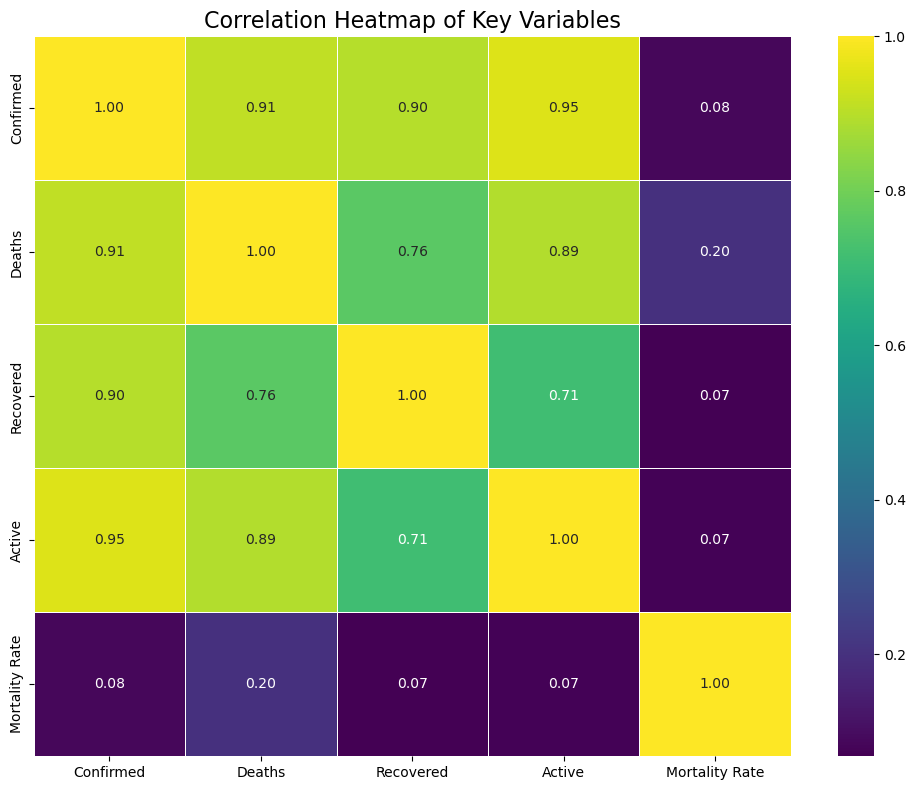

<Figure size 640x480 with 0 Axes>

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for the specified columns
correlation_matrix = covid19_clean[['Confirmed', 'Deaths', 'Recovered', 'Active', 'Mortality Rate']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)

# Add title
plt.title('Correlation Heatmap of Key Variables', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

# Save and show the plot
plt.savefig("Correlation Heatmap of Key Variables.png", dpi=300)  # Save with higher resolution
plt.show()

covid19_clean['Daily Growth Rate'] = covid19_clean['Confirmed'].pct_change().fillna(0)
covid19_clean['Mortality Rate'] = (covid19_clean['Deaths'] / covid19_clean['Confirmed']) * 100
covid19_clean['Cases per 100k Population'] = (covid19_clean['Confirmed'] / covid19_clean['Population']) * 100000

In [36]:
# Model Development: Classification
# Prepare features and target variable
if 'Mortality Rate' in country_wise.columns and 'Confirmed' in country_wise.columns and 'Deaths' in country_wise.columns:
    print("Required columns are present in the dataset.")

    # Feature Engineering
    country_wise['Cases per 100k Population'] = (country_wise['Confirmed'] / 1_000_000) * 100_000
    X = country_wise[['Confirmed', 'Deaths']].fillna(0)  # Simplified for testing
    y = (country_wise['Mortality Rate'] > 2).astype(int)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

In [37]:
# Check and calculate 'Mortality Rate' if missing
if 'Mortality Rate' not in country_wise.columns:
    print("Calculating 'Mortality Rate'...")
    # Avoid division by zero
    country_wise['Mortality Rate'] = (country_wise['Deaths'] / country_wise['Confirmed']).replace([float('inf'), -float('inf')], 0).fillna(0) * 100

Calculating 'Mortality Rate'...


Required columns are present in the dataset.
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        26
           1       0.91      1.00      0.95        31

    accuracy                           0.95        57
   macro avg       0.96      0.94      0.95        57
weighted avg       0.95      0.95      0.95        57

ROC-AUC Score: 0.9255583126550868


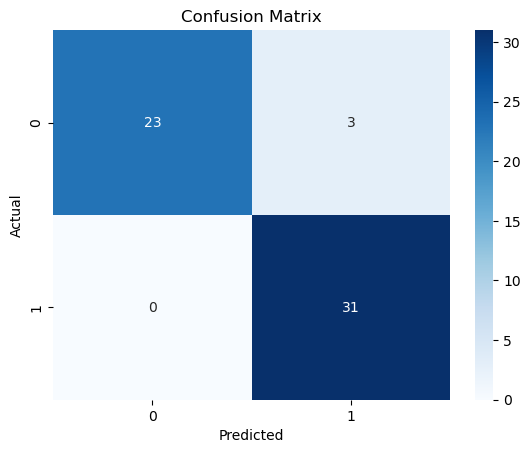

In [38]:
# Proceed with classification
if 'Mortality Rate' in country_wise.columns and 'Confirmed' in country_wise.columns and 'Deaths' in country_wise.columns:
    print("Required columns are present in the dataset.")

    # Feature Engineering
    country_wise['Cases per 100k Population'] = (country_wise['Confirmed'] / 1_000_000) * 100_000
    X = country_wise[['Confirmed', 'Deaths']].fillna(0)  # Simplified for testing
    y = (country_wise['Mortality Rate'] > 2).astype(int)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Classification Metrics
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

else:
    print("Error: Required columns are missing in the dataset.")

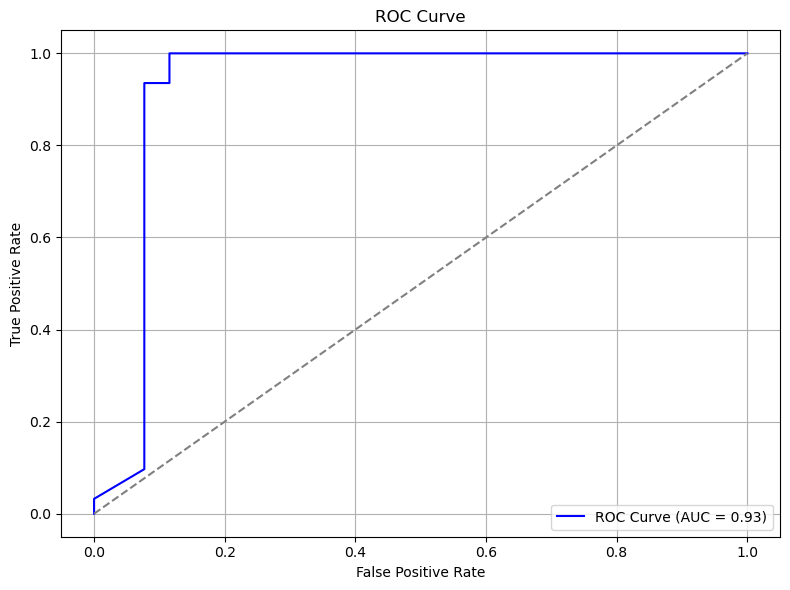

In [39]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# Inspect the time-series dataset
print(full_grouped.head())
print(full_grouped.columns)

         Date Country/Region  Confirmed  Deaths  Recovered  Active  New cases  \
0  2020-01-22    Afghanistan          0       0          0       0          0   
1  2020-01-22        Albania          0       0          0       0          0   
2  2020-01-22        Algeria          0       0          0       0          0   
3  2020-01-22        Andorra          0       0          0       0          0   
4  2020-01-22         Angola          0       0          0       0          0   

   New deaths  New recovered             WHO Region  
0           0              0  Eastern Mediterranean  
1           0              0                 Europe  
2           0              0                 Africa  
3           0              0                 Europe  
4           0              0                 Africa  
Index(['Date', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'New cases', 'New deaths', 'New recovered', 'WHO Region'],
      dtype='object')


In [41]:
# Ensure consistent column names
worldometer.rename(columns={'Country/Region': 'Country'}, inplace=True)

# Reset the index of the time-series dataset to merge on 'Country'
time_series_data = full_grouped.reset_index()

# Merge datasets on 'Country'
merged_data = pd.merge(time_series_data, worldometer[['Country', 'Population']], 
                       left_on='Country/Region', right_on='Country', how='left')

# Drop the extra 'Country' column post-merge
merged_data.drop('Country', axis=1, inplace=True)

# Set 'Date' back as the index
merged_data.set_index('Date', inplace=True)

# Check the merged dataset
print(merged_data.head())

            index Country/Region  Confirmed  Deaths  Recovered  Active  \
Date                                                                     
2020-01-22      0    Afghanistan          0       0          0       0   
2020-01-22      1        Albania          0       0          0       0   
2020-01-22      2        Algeria          0       0          0       0   
2020-01-22      3        Andorra          0       0          0       0   
2020-01-22      4         Angola          0       0          0       0   

            New cases  New deaths  New recovered             WHO Region  \
Date                                                                      
2020-01-22          0           0              0  Eastern Mediterranean   
2020-01-22          0           0              0                 Europe   
2020-01-22          0           0              0                 Africa   
2020-01-22          0           0              0                 Europe   
2020-01-22          0          

In [42]:
# Fill missing values in Population with the median
merged_data['Population'].fillna(merged_data['Population'].median(), inplace=True)

# Check for remaining missing values
print(merged_data.isnull().sum())

index             0
Country/Region    0
Confirmed         0
Deaths            0
Recovered         0
Active            0
New cases         0
New deaths        0
New recovered     0
WHO Region        0
Population        0
dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_6904\139190046.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['Population'].fillna(merged_data['Population'].median(), inplace=True)


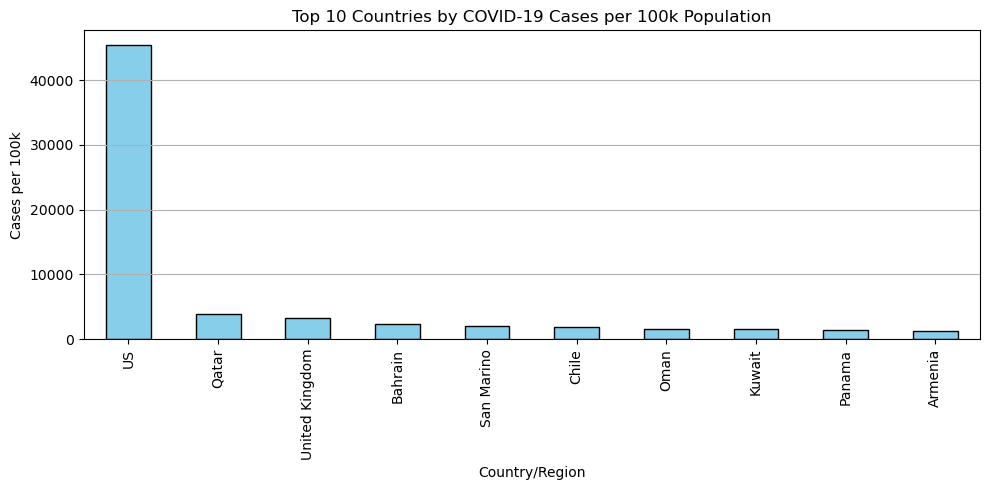

<Figure size 640x480 with 0 Axes>

In [43]:
# Calculate cases per 100k population
merged_data['Cases per 100k'] = (merged_data['Confirmed'] / merged_data['Population']) * 100000

# Plot top 10 countries by cases per 100k
top_countries = merged_data.groupby('Country/Region')['Cases per 100k'].max().sort_values(ascending=False).head(10)


top_countries.plot(kind='bar', figsize=(10, 5), color='skyblue', edgecolor='black')
plt.title('Top 10 Countries by COVID-19 Cases per 100k Population')
plt.ylabel('Cases per 100k')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Save and show the plot
plt.savefig("Top 10 Countries by COVID-19 Cases per 100k Population.png", dpi=300)  # Save with higher resolution
plt.show()

# Predictive Modeling
# Time-Series Forecasting:

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

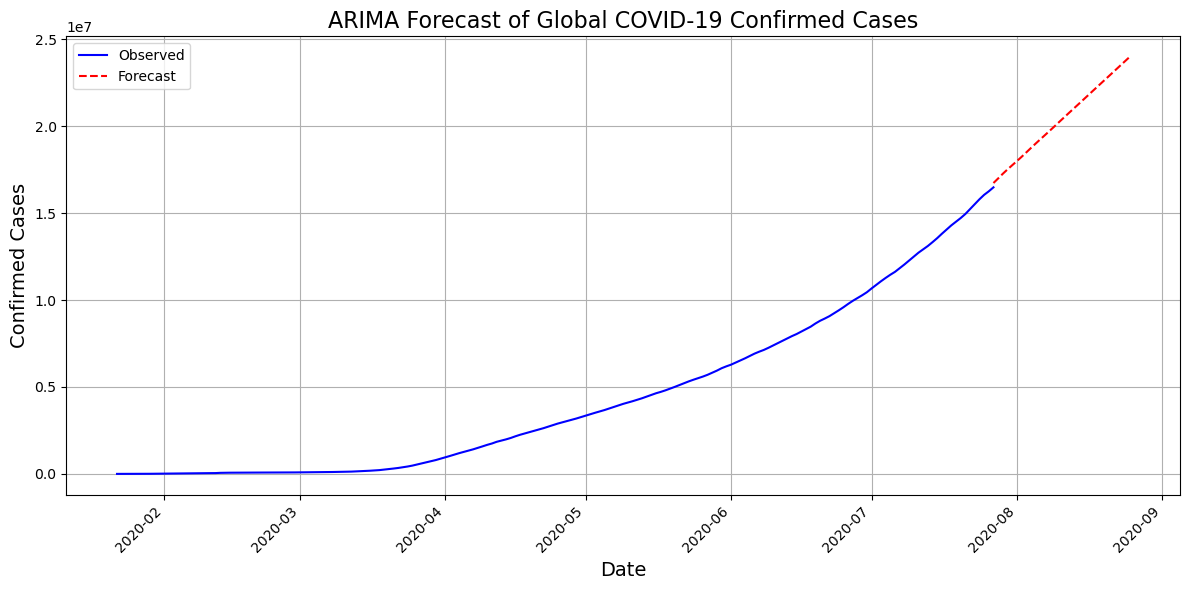

In [44]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'Date' is in the correct datetime format and set as index
covid19_clean['Date'] = pd.to_datetime(covid19_clean['Date'], errors='coerce')
covid19_clean = covid19_clean.dropna(subset=['Date', 'Confirmed'])  # Drop rows with missing dates or confirmed cases
covid19_clean.set_index('Date', inplace=True)

# Aggregate global confirmed cases by date
global_trends = covid19_clean.groupby('Date')['Confirmed'].sum()

# Fit ARIMA model on global confirmed cases
model_arima = ARIMA(global_trends, order=(5, 1, 0))  # Adjust parameters if necessary
arima_fit = model_arima.fit()

# Forecast next 30 days
forecast = arima_fit.forecast(steps=30)

# Generate forecast dates
forecast_dates = pd.date_range(global_trends.index[-1], periods=30, freq='D')

# Plot observed vs. forecasted data
plt.figure(figsize=(12, 6))  # Increase figure size
plt.plot(global_trends, label='Observed', color='blue')  # Historical data
plt.plot(forecast_dates, forecast, label='Forecast', color='red', linestyle='--')  # Forecasted data
plt.title('ARIMA Forecast of Global COVID-19 Confirmed Cases', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Confirmed Cases', fontsize=14)

# Format the x-axis for better readability
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save and show the plot
plt.savefig("ARIMA_Forecast_Global_COVID19.png", dpi=300)  # Save with higher resolution
plt.show()